# 广告投入与产品销量预测

该数据集来自Advertising.csv是来自
http://faculty.marshall.usc.edu/gareth-james/ISL/Advertising.csv

数据集包含200个样本，每个样本有3个输入属性：
1. 电视广告投入
2. 收音机广告投入
3. 报纸广告
以及一个输出/响应：
4. 产品销量

## 1. 导入必要的工具包

In [19]:
#数据处理
import numpy as np 
import pandas as pd 

#数据可视化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 使用r2_score作为回归模型性能的评价
from sklearn.metrics import r2_score  

#显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

## 2. 读取数据

In [20]:
#读取数据
dpath = "./data/"
df = pd.read_csv(dpath + "Advertising.csv")

#通过观察前5行，了解数据每列（特征）的概况
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


## 3. 数据准备

In [21]:
# 从原始数据中分离输入特征x和输出y
#去掉索引列
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

y = df['sales']
X = df.drop('sales', axis = 1)

#特征名称，用于后续显示权重系数对应的特征
feat_names = X.columns

In [22]:
#log变换

X = np.log1p(X)
y = np.log1p(y)

In [23]:
#将数据分割训练数据与测试数据
from sklearn.model_selection import train_test_split

# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)
#X_train.shape

## 4. 最小二乘线性回归

In [24]:
# 线性回归
from sklearn.linear_model import LinearRegression

# 1.使用默认配置初始化学习器实例
lr = LinearRegression()

# 2.用训练数据训练模型参数
lr.fit(X_train, y_train)

# 3. 用训练好的模型对测试集进行预测
y_test_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(X_train)


#性能评估，R方分数
print("The r2 score of LinearRegression on test is %f" %(r2_score(y_test, y_test_pred_lr)))
print("The r2 score of LinearRegression on train is %f" %(r2_score(y_train, y_train_pred_lr)))

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef":list((lr.coef_.T))})
#fs.sort_values(by=['coef'],ascending=False)
fs = fs.append([{'columns':'intercept','coef':lr.intercept_}], ignore_index=True)
fs

The r2 score of LinearRegression on test is 0.902478
The r2 score of LinearRegression on train is 0.942929


,coef,columns
0,0.339085,TV
1,0.195246,radio
2,0.017763,newspaper
3,0.432277,intercept


## 残差分布

Text(0.5,0,u'\u6b8b\u5dee')

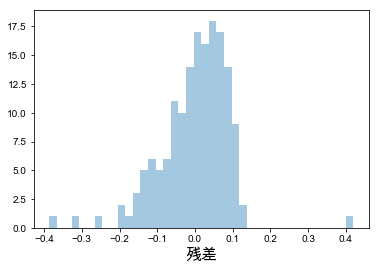

In [25]:
#在训练集上观察预测残差的分布，看是否符合模型假设：噪声为0均值的高斯噪声
figsize = 11,9
res = y_train_pred_lr - y_train
sns.distplot(res, bins=40, kde = False)
plt.xlabel(u'残差', fontsize = 16)

看起来残差的分布并不符合0均值的正态分布

Text(0,0.5,u'\u6b8b\u5dee')

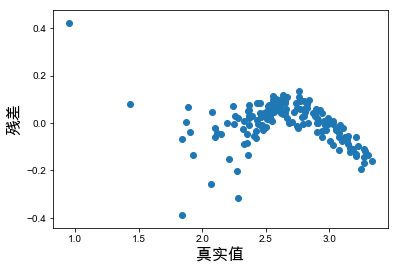

In [26]:
figsize = 11,9
plt.scatter(y_train, res)
plt.xlabel(u'真实值', fontsize = 16)
plt.ylabel(u'残差', fontsize = 16)

从真实值和残差的散点图来看，真实值和残差不是没有关系。看起来真实值较小和较大时，预测残差大多<0,其余情况残差大多>0。
也就是说，模型还没有完全建模y与x之间的关系，还有一部分关系残留在残差中。

## 5. 岭回归

In [27]:
from sklearn.linear_model import  RidgeCV

#1. 设置超参数（正则参数）范围
alphas = [ 0.01, 0.1, 1, 10, 100]

#2. 生成一个RidgeCV实例
ridge = RidgeCV(alphas=alphas, store_cv_values=True)  

#3. 模型训练
ridge.fit(X_train, y_train)    

#4. 预测
y_test_pred_ridge = ridge.predict(X_test)
y_train_pred_ridge = ridge.predict(X_train)

#模型性能评估
print("The r2 score of Ridge on test is %f" %(r2_score(y_test, y_test_pred_ridge)))
print("The r2 score of Ridge on train is %f" %(r2_score(y_train, y_train_pred_ridge)))

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef":list((ridge.coef_.T))})
#fs.sort_values(by=['coef'],ascending=False)
fs = fs.append([{'columns':'intercept','coef':ridge.intercept_}], ignore_index=True)
fs

The r2 score of Ridge on test is 0.902772
The r2 score of Ridge on train is 0.942929


,coef,columns
0,0.338853,TV
1,0.195086,radio
2,0.017785,newspaper
3,0.433771,intercept


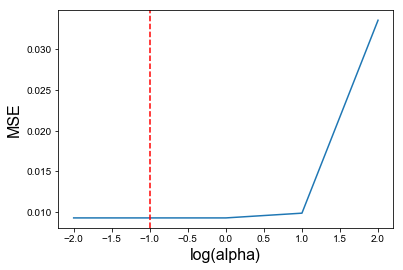

('alpha is:', 0.1)


In [28]:
mse_mean = np.mean(ridge.cv_values_, axis = 0)
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas),1)) 

#最佳超参数
plt.axvline(np.log10(ridge.alpha_), color='r', ls='--')

plt.xlabel('log(alpha)', fontsize = 16)
plt.ylabel('MSE', fontsize = 16)
plt.show()

print ('alpha is:', ridge.alpha_)

## 6. Lasso回归

In [29]:
from sklearn.linear_model import LassoCV

#1. 设置超参数搜索范围
#Lasso可以自动确定最大的alpha，所以另一种设置alpha的方式是设置最小的alpha值（eps） 和 超参数的数目（n_alphas），
#然后LassoCV对最小值和最大值之间在log域上均匀取值n_alphas个
# np.logspace(np.log10(alpha_max * eps), np.log10(alpha_max),num=n_alphas)[::-1]

#2 生成LassoCV实例（默认超参数搜索范围）
lasso = LassoCV()  

#3. 训练（内含CV）
lasso.fit(X_train, y_train)  

#4. 测试
y_test_pred_lasso = lasso.predict(X_test)
y_train_pred_lasso = lasso.predict(X_train)


# 评估，使用r2_score评价模型在测试集和训练集上的性能
print("The r2 score of lasso on test is %f" %(r2_score(y_test, y_test_pred_lasso)))
print("The r2 score of lasso on train is %f" %(r2_score(y_train, y_train_pred_lasso)))

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T))})
#fs.sort_values(by=['coef_lr'],ascending=False)
fs = fs.append([{'columns':'intercept','coef_lr':lr.intercept_, 'coef_ridge':ridge.intercept_, 'coef_lasso':lasso.intercept_}], ignore_index=True)
fs

The r2 score of lasso on test is 0.907140
The r2 score of lasso on train is 0.942804


,coef_lasso,coef_lr,coef_ridge,columns
0,0.336586,0.339085,0.338853,TV
1,0.192653,0.195246,0.195086,radio
2,0.015176,0.017763,0.017785,newspaper
3,0.459732,0.432277,0.433771,intercept


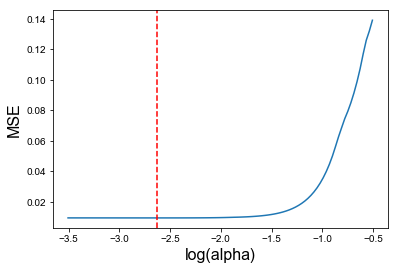

('alpha is:', 0.0023597497783513707)


In [30]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 

#最佳超参数
plt.axvline(np.log10(lasso.alpha_), color='r', ls='--')

plt.xlabel('log(alpha)', fontsize = 16)
plt.ylabel('MSE', fontsize = 16)
plt.show()    
            
print ('alpha is:', lasso.alpha_)

In [31]:
from sklearn.linear_model import ElasticNetCV

#1. 设置超参数搜索范围
#Lasso可以自动确定最大的alpha，所以另一种设置alpha的方式是设置最小的alpha值（eps） 和 超参数的数目（n_alphas），
#然后LassoCV对最小值和最大值之间在log域上均匀取值n_alphas个
# np.logspace(np.log10(alpha_max * eps), np.log10(alpha_max),num=n_alphas)[::-1]
l1_ratio = [0.01, 0.1, .5, .7, .9, .95, .99, 1]

#2 ElasticNetCV（设置超参数搜索范围）
elastic_net = ElasticNetCV(l1_ratio = l1_ratio )  

#3. 训练（内含CV）
elastic_net.fit(X_train, y_train)  

#4. 测试
y_test_pred_elastic_net = elastic_net.predict(X_test)
y_train_pred_elastic_net = elastic_net.predict(X_train)


# 评估，使用r2_score评价模型在测试集和训练集上的性能
print("The r2 score of elastic_net on test is %f" %(r2_score(y_test, y_test_pred_elastic_net)))
print("The r2 score of elastic_net on train is %f" %(r2_score(y_train, y_train_pred_elastic_net)))

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T)), 'coef_elastic_net':list((elastic_net.coef_.T))})
#fs.sort_values(by=['coef_lr'],ascending=False)
fs = fs.append([{'columns':'intercept','coef_lr':lr.intercept_, 'coef_ridge':ridge.intercept_, 'coef_lasso':lasso.intercept_, 'coef_elastic_net':elastic_net.intercept_}], ignore_index=True)
fs

The r2 score of elastic_net on test is 0.909407
The r2 score of elastic_net on train is 0.942667


,coef_elastic_net,coef_lasso,coef_lr,coef_ridge,columns
0,0.333974,0.336586,0.339085,0.338853,TV
1,0.191295,0.192653,0.195246,0.195086,radio
2,0.016850,0.015176,0.017763,0.017785,newspaper
3,0.470784,0.459732,0.432277,0.433771,intercept


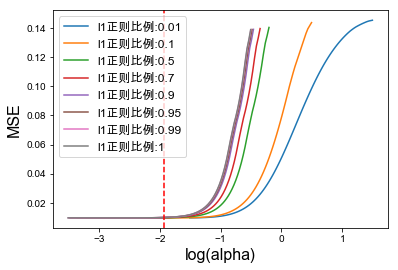

('alpha is:', 0.011744530252782244)
('l1_ratio is:', 0.1)


In [32]:
mses = np.mean(elastic_net.mse_path_, axis = 2)

# plot results
n_l1_ratio = len(l1_ratio)
n_alpha = elastic_net.alphas_.shape[1]

for i, l1 in enumerate(l1_ratio):
    plt.plot(np.log10(elastic_net.alphas_[i]), mses[i], label= u'l1正则比例:' + str(l1))

#最佳超参数
plt.axvline(np.log10(elastic_net.alpha_), color='r', ls='--')

plt.xlabel('log(alpha)', fontsize = 16)
plt.ylabel('MSE', fontsize = 16)
plt.legend(fontsize = 12)
plt.show()    
            
print ('alpha is:', elastic_net.alpha_)
print ('l1_ratio is:', elastic_net.l1_ratio_)

## 默认超参数的Huber损失回归
注意默认超参数alpha=0.0001
如果要对HuberRegressor模型超参数调优，可结合GridSearchCV

In [33]:
# Huber回归
from sklearn.linear_model import HuberRegressor

# 1.使用默认配置初始化学习器实例
hr = HuberRegressor()

# 2.用训练数据训练模型参数
hr.fit(X_train, y_train)

# 3. 用训练好的模型对测试集进行预测
y_test_pred_hr = hr.predict(X_test)
y_train_pred_hr = hr.predict(X_train)


# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef":list((hr.coef_.T))})
#fs.sort_values(by=['coef'],ascending=False)
fs = fs.append([{'columns':'intercept','coef':hr.intercept_}], ignore_index=True)
fs

,coef,columns
0,0.336551,TV
1,0.226304,radio
2,0.012068,newspaper
3,0.357236,intercept


Text(0.5,1,u'\u6b8b\u5dee\u76f4\u65b9\u56fe')

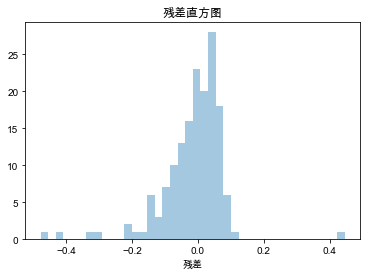

In [34]:
#在训练集上观察预测残差的分布，看是否符合模型假设：噪声为0均值的高斯噪声
figsize = 11,9
res =  y_train_pred_hr - y_train
sns.distplot(res, bins=40, kde = False)
plt.xlabel(u'残差')
plt.title(u'残差直方图') 

Text(0,0.5,u'\u6b8b\u5dee')

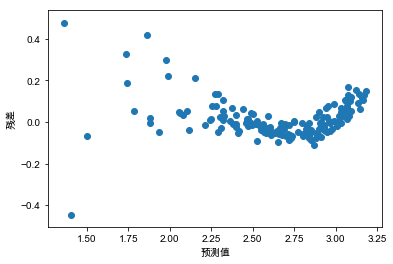

In [35]:
figsize = 11,9

res = y_train - y_train_pred_hr
plt.scatter(y_train_pred_hr, res)
plt.xlabel(u'预测值')
plt.ylabel(u'残差')